In [2]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

In [3]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

In [4]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [5]:
# using stratifiedStuffleSplit 
from sklearn.model_selection import StratifiedShuffleSplit
# n_splits= 1 category, test_size: total 40 people, 10 images per person, total 400 images, use test_size of 40, one for each person
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)

# setup train and test data
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))

X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]

X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

In [6]:
X_train_valid.shape, y_train_valid.shape

((360, 4096), (360,))

In [7]:
# split train data into train and validate set
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)

train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))

X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]

X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [8]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


In [9]:
# using PCA for dimension reduction
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

In [10]:
# cluster images using K-Means
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    #print(f"k={k}")
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_train_pca)
    kmeans_per_k.append(kmeans)

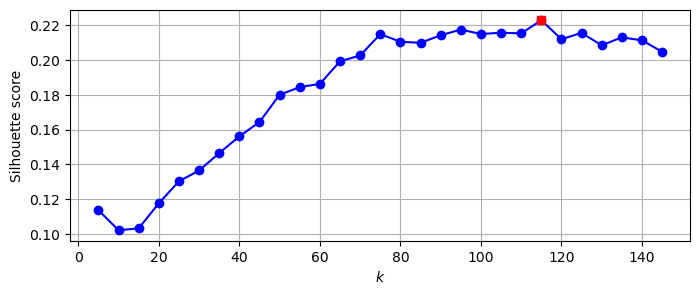

In [11]:
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
import numpy as np

# silhouette_score: between -1 to 1, -1, instance is well inside its own cluster, 0, instance is at a cluster boundary, -1, instance assigned to the wrong cluster

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.plot(best_k, best_score, "rs")
plt.grid()
plt.show()

In [12]:
best_k

115

In [13]:
# there are total of 40 people, but got 115 cluster as optimum

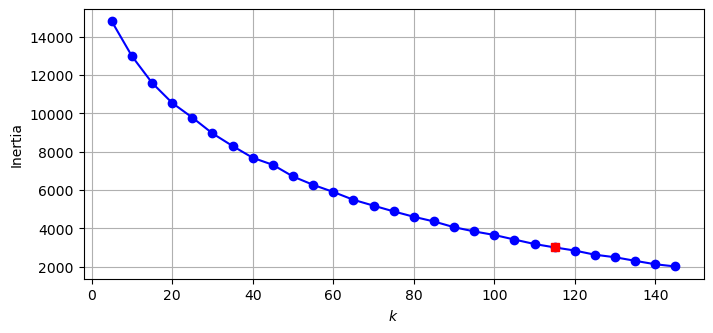

In [14]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.plot(best_k, best_inertia, "rs")
plt.grid()
plt.show()

In [15]:
# using Gaussian Mixture Mode

from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

In [27]:
len(np.intersect1d(y_pred, y_train)) / len(y_train) 

0.14285714285714285